# Matrix Factorization Visualizations

## Simple SGD from Homework

In [1]:
import utils
import matrix_factorization as mf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
sns.set()
sns.set_style("white")

In [2]:
# Y_train = utils.get_training_data()
# Y_test = utils.get_test_data()
Y = utils.get_data()
movie_id, movie_title, movie_genre, genres = utils.get_movies()
genre_similarity = utils.genre_similarity(movie_genre)

M = 943 # users
N = 1682 # movies
K = 20
reg = 0.1
eta = 0.03

In [3]:
U, V, err = mf.train_model(Y, M, N, K, eta, reg)
print(U.shape, V.shape)

Epoch  0: current avarage training error 0.492
Epoch  1: current avarage training error 0.436
Epoch  2: current avarage training error 0.412
Epoch  3: current avarage training error 0.398
Epoch  4: current avarage training error 0.391
Epoch  5: current avarage training error 0.378
Epoch  6: current avarage training error 0.368
Epoch  7: current avarage training error 0.359
Epoch  8: current avarage training error 0.356
Epoch  9: current avarage training error 0.348
Epoch 10: current avarage training error 0.340
Epoch 11: current avarage training error 0.335
Epoch 12: current avarage training error 0.332
Epoch 13: current avarage training error 0.328
Epoch 14: current avarage training error 0.323
Epoch 15: current avarage training error 0.322
(20, 943) (20, 1682)


In [ ]:
# print('Average training error =', '{:.3f}'.format(err/len(Y_train)))
# print('Average test error =', '{:.3f}'.format(err_test/len(Y_test)))

In [4]:
A, S, B = np.linalg.svd(V) # SVD for the latent factor of the movies
print(A.shape, S.shape, B.shape)
V2 = A.T[:2, :]@V # Project V to 2D
print(V2.shape)

(20, 20) (20,) (1682, 1682)
(2, 1682)


In [7]:
YM = utils.list_to_matrix(Y, M, N)
counts, ratings, ratings_bayesian = utils.bayesian_rating(Y, thr=4)
rank_counts = np.argsort(-counts) # Indices of counts in descending order
rank_ratings = np.argsort(-ratings) # Indices of ratings in descending order
rank_ratings_bayesian = np.argsort(-ratings_bayesian) # Indices of ratings in descending order
print(ratings[rank_ratings[:5]], counts[rank_ratings[:5]])
print(ratings[rank_ratings_bayesian[:5]], counts[rank_ratings_bayesian[:5]])
print(movie_title[rank_ratings_bayesian[:5]])

[5. 5. 5. 5. 5.] [1 1 2 1 3]
[4.49107143 4.46644295 4.45679012 4.46610169 4.44522968] [112 298 243 118 283]
['"Close Shave, A (1995)"' "Schindler's List (1993)" 'Casablanca (1942)'
 '"Wrong Trousers, The (1993)"' '"Shawshank Redemption, The (1994)"']


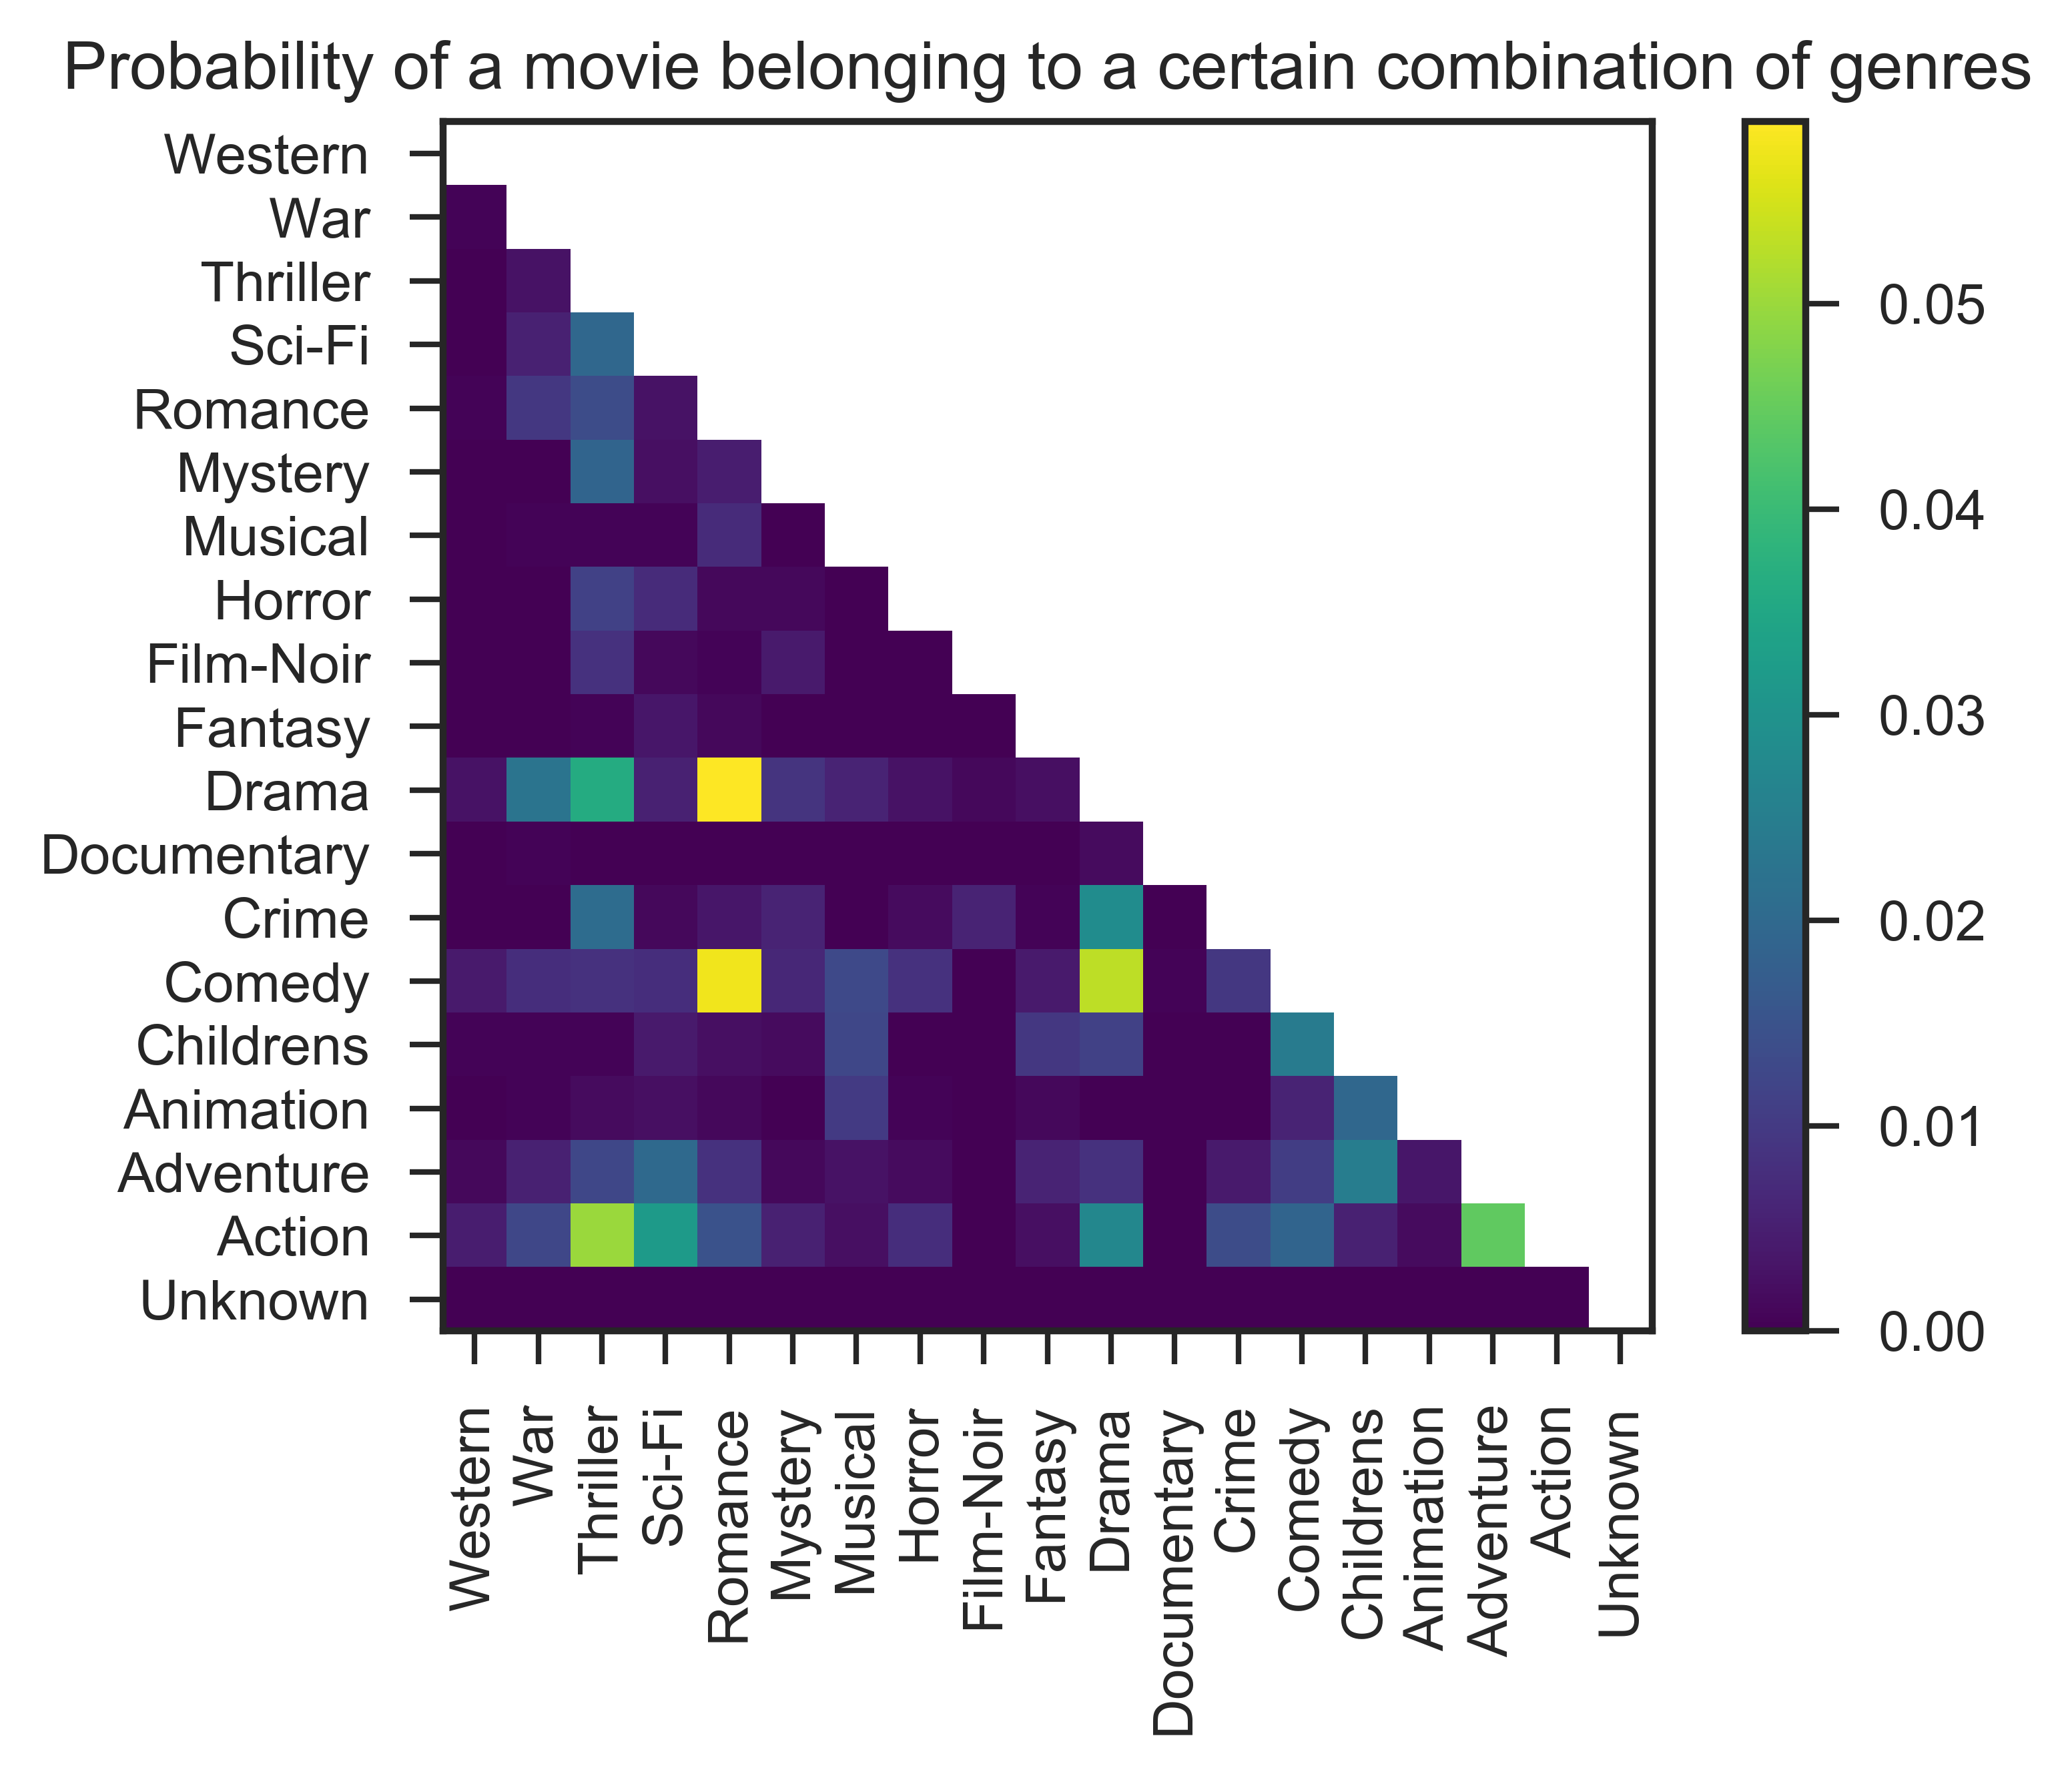

In [29]:
sns.set_style("ticks")
n_genres = len(genres)
genre_similarity_nodiag = genre_similarity.copy()
for i in range(n_genres):
    genre_similarity_nodiag[i, i] = np.nan
plt.figure(dpi=300)
plt.imshow(np.rot90(genre_similarity_nodiag, 2), extent=[0.5, n_genres+0.5, 0.5, n_genres+0.5],
          cmap='viridis')
plt.xticks(np.arange(n_genres)+1, genres[::-1], rotation='vertical')
plt.yticks(np.arange(n_genres)+1, genres)
plt.colorbar()
plt.title('Probability of a movie belonging to a certain combination of genres')
plt.show()

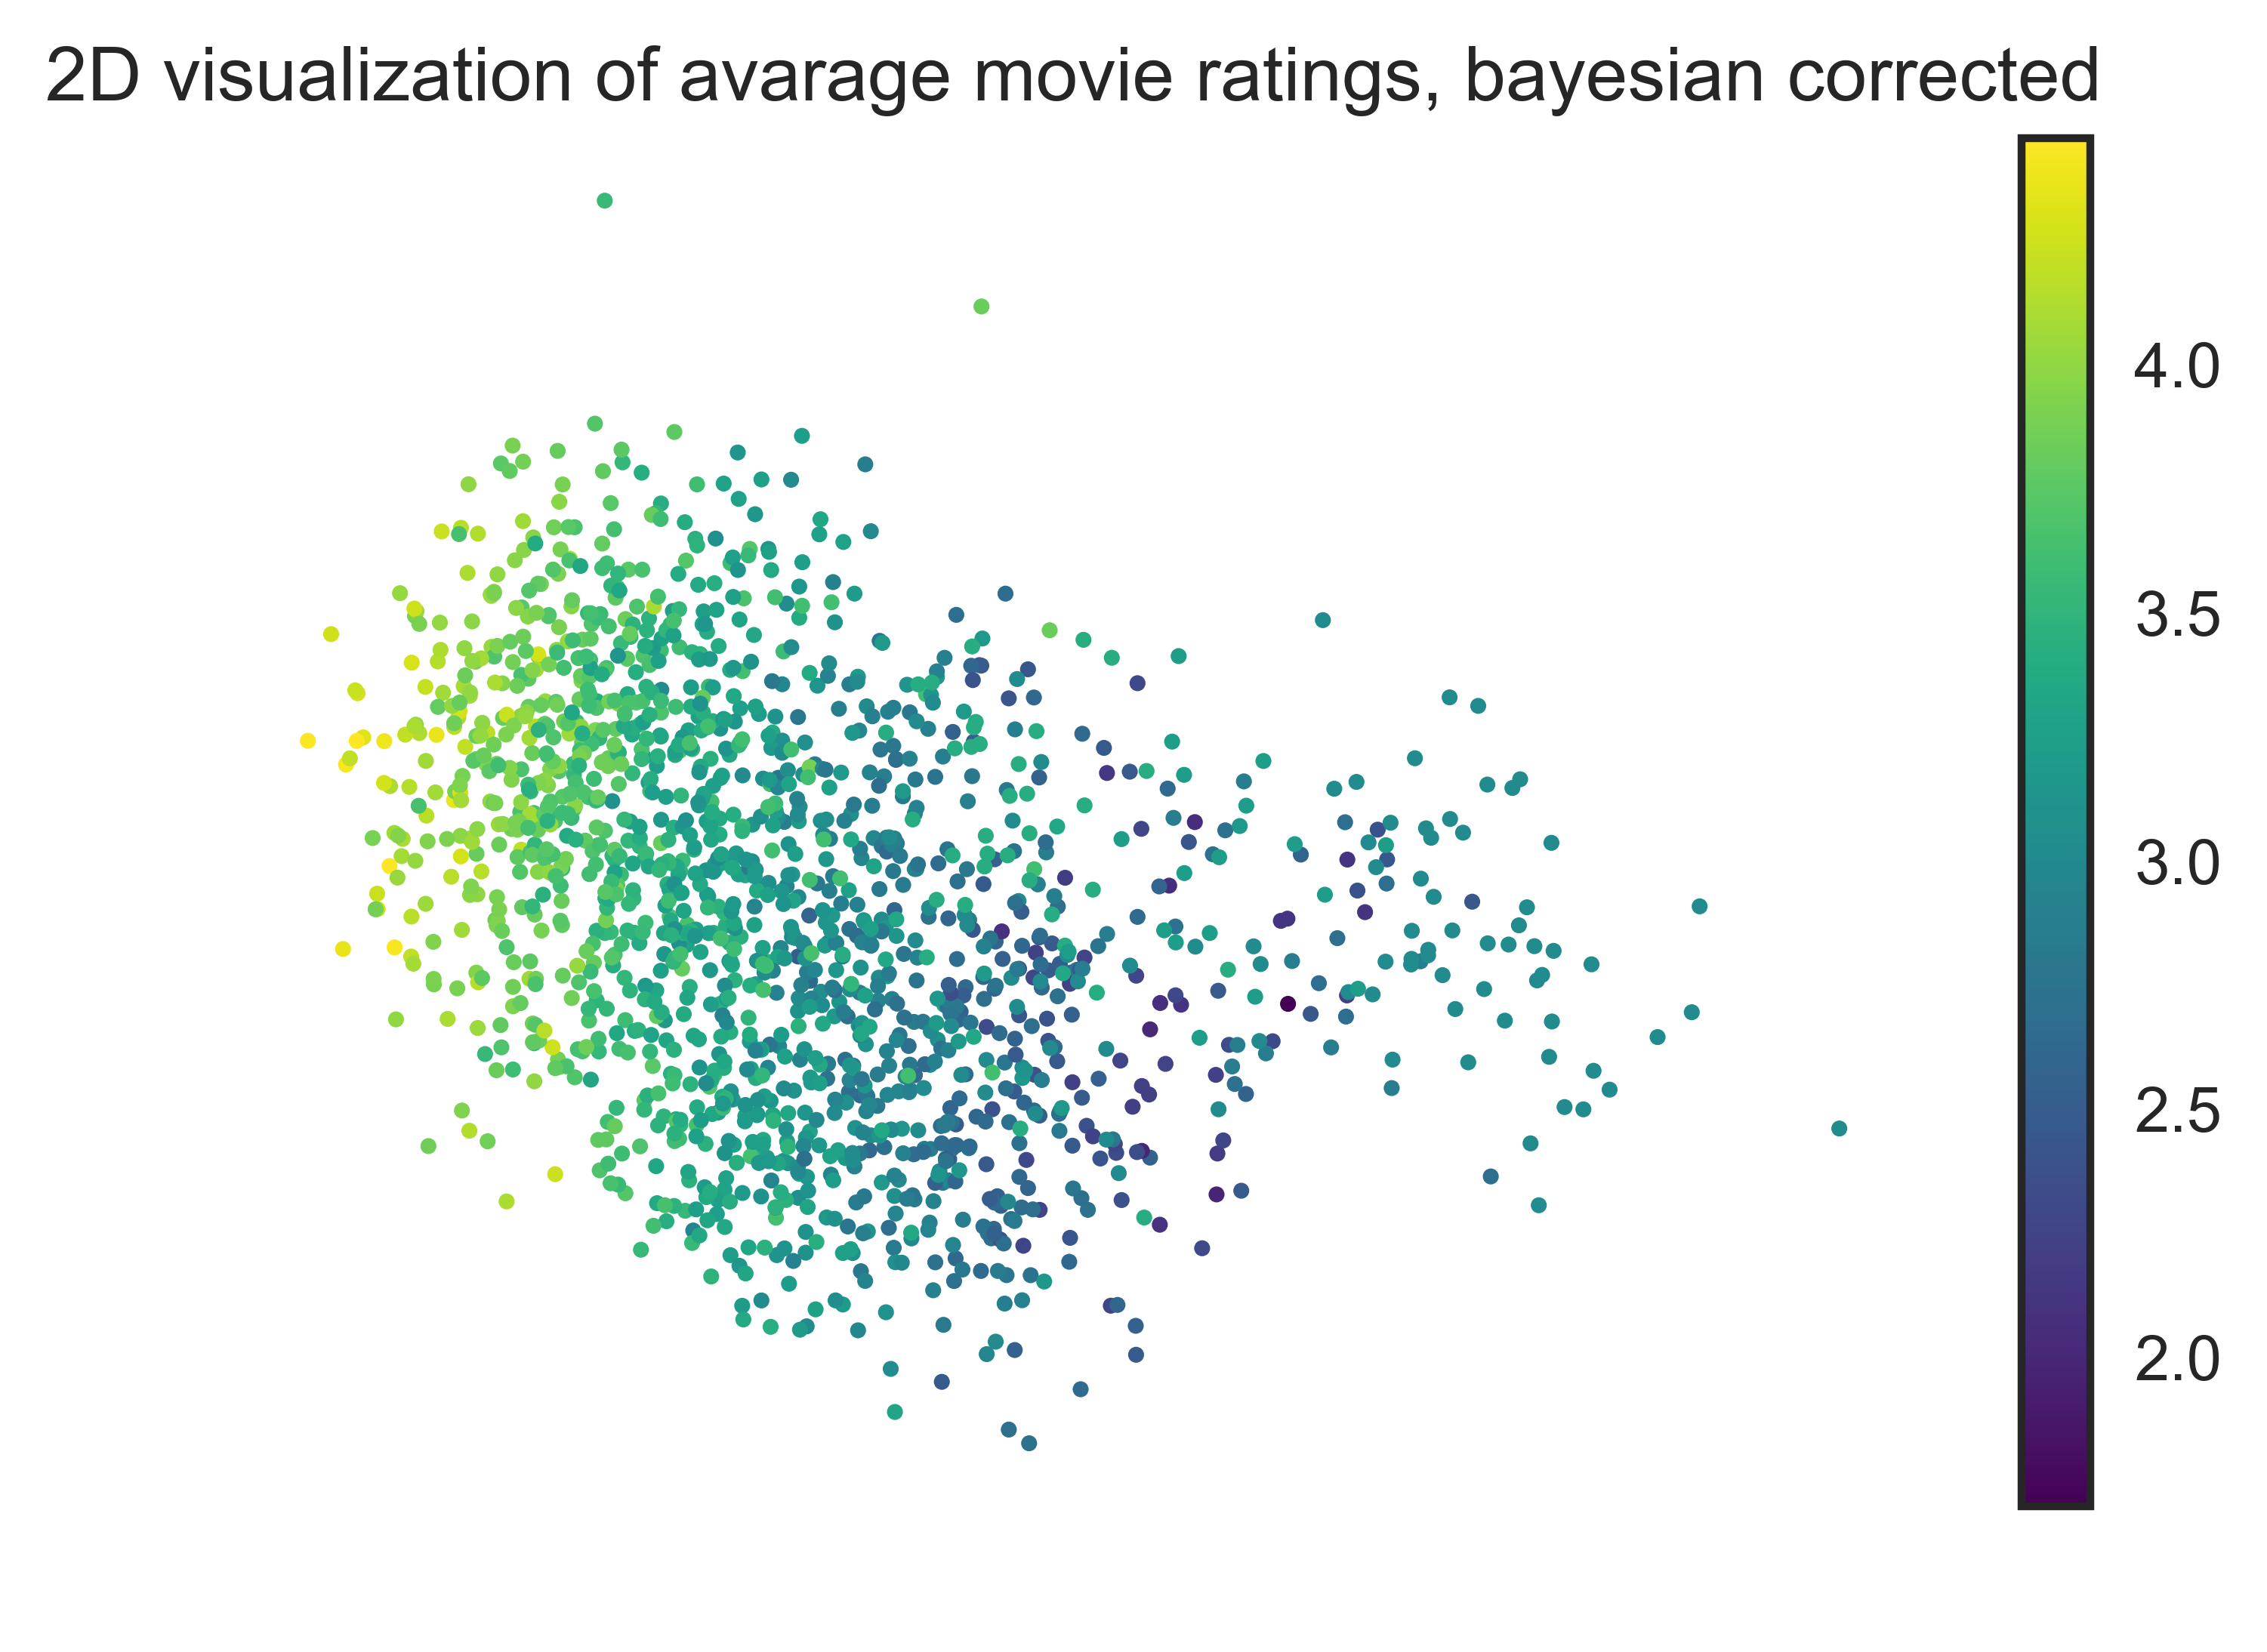

In [10]:
plt.figure(dpi=300)
plt.scatter(V2[0, :], V2[1, :], 5, ratings_bayesian, cmap='viridis')
plt.title('2D visualization of avarage movie ratings, bayesian corrected')
plt.colorbar()
plt.axis('off')
plt.show()

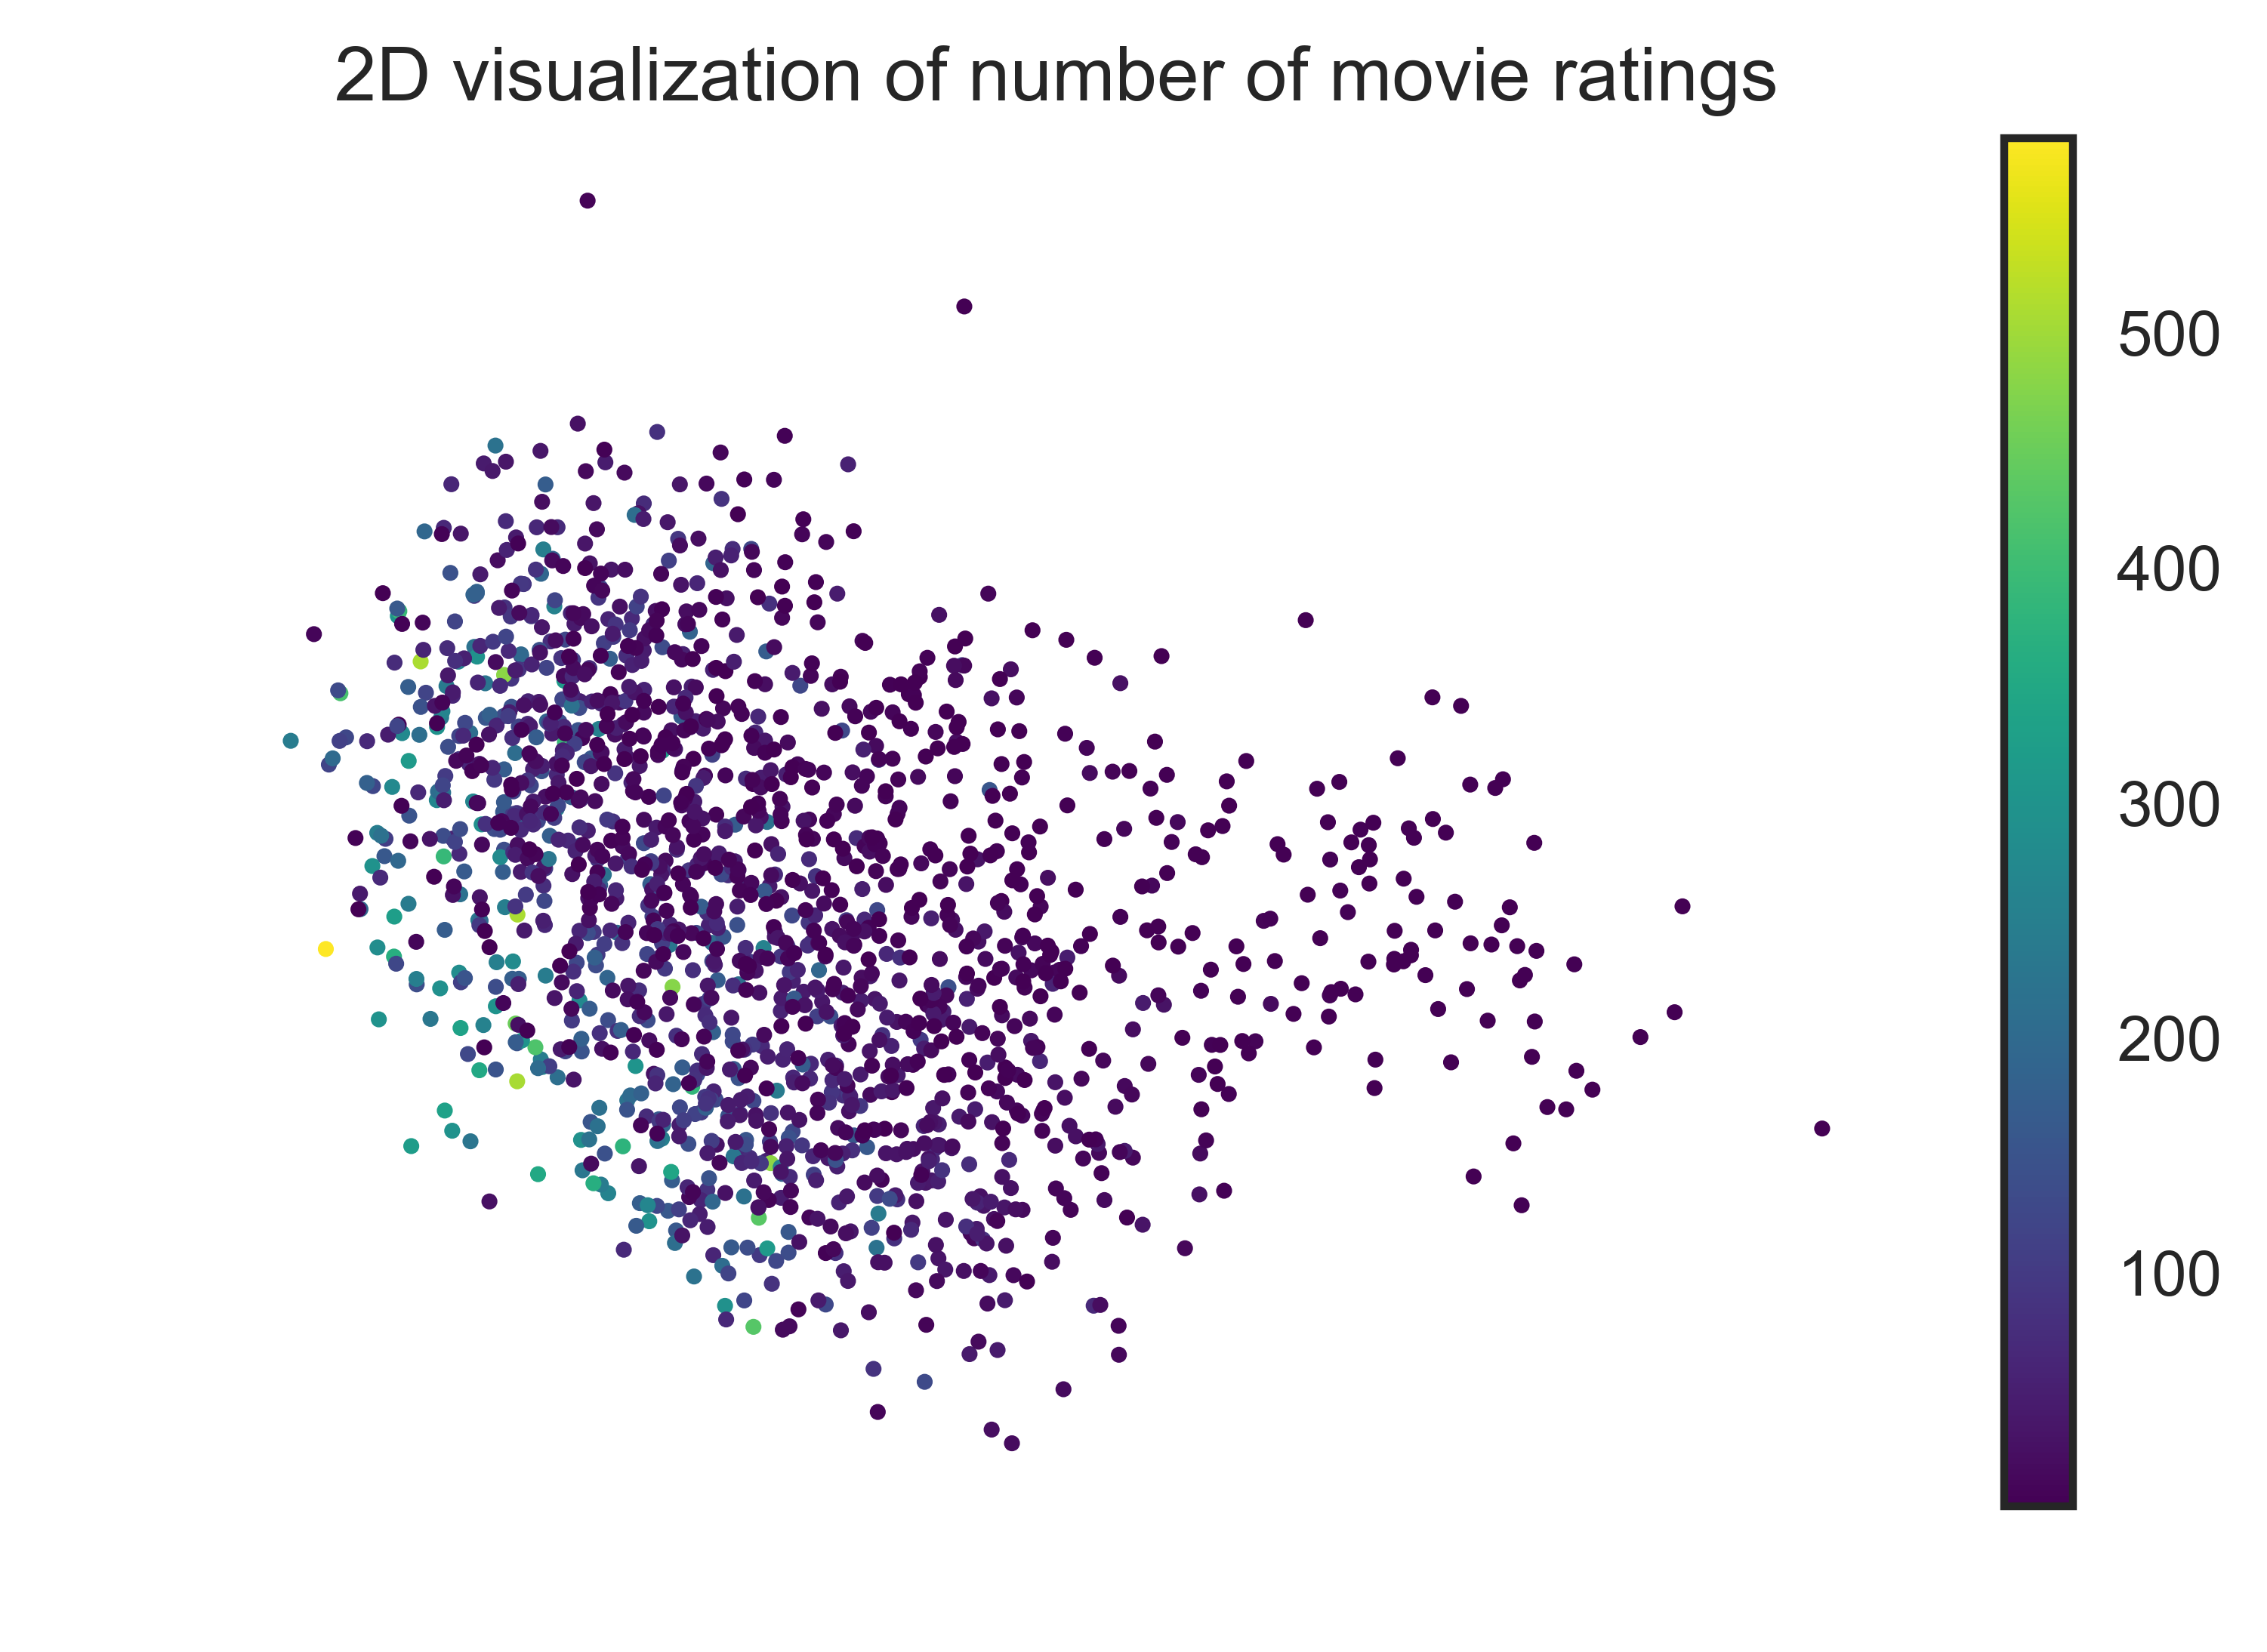

In [11]:
plt.figure(dpi=300)
plt.scatter(V2[0, :], V2[1, :], 5, counts, cmap='viridis')
plt.title('2D visualization of number of movie ratings')
plt.colorbar()
plt.axis('off')
plt.show()

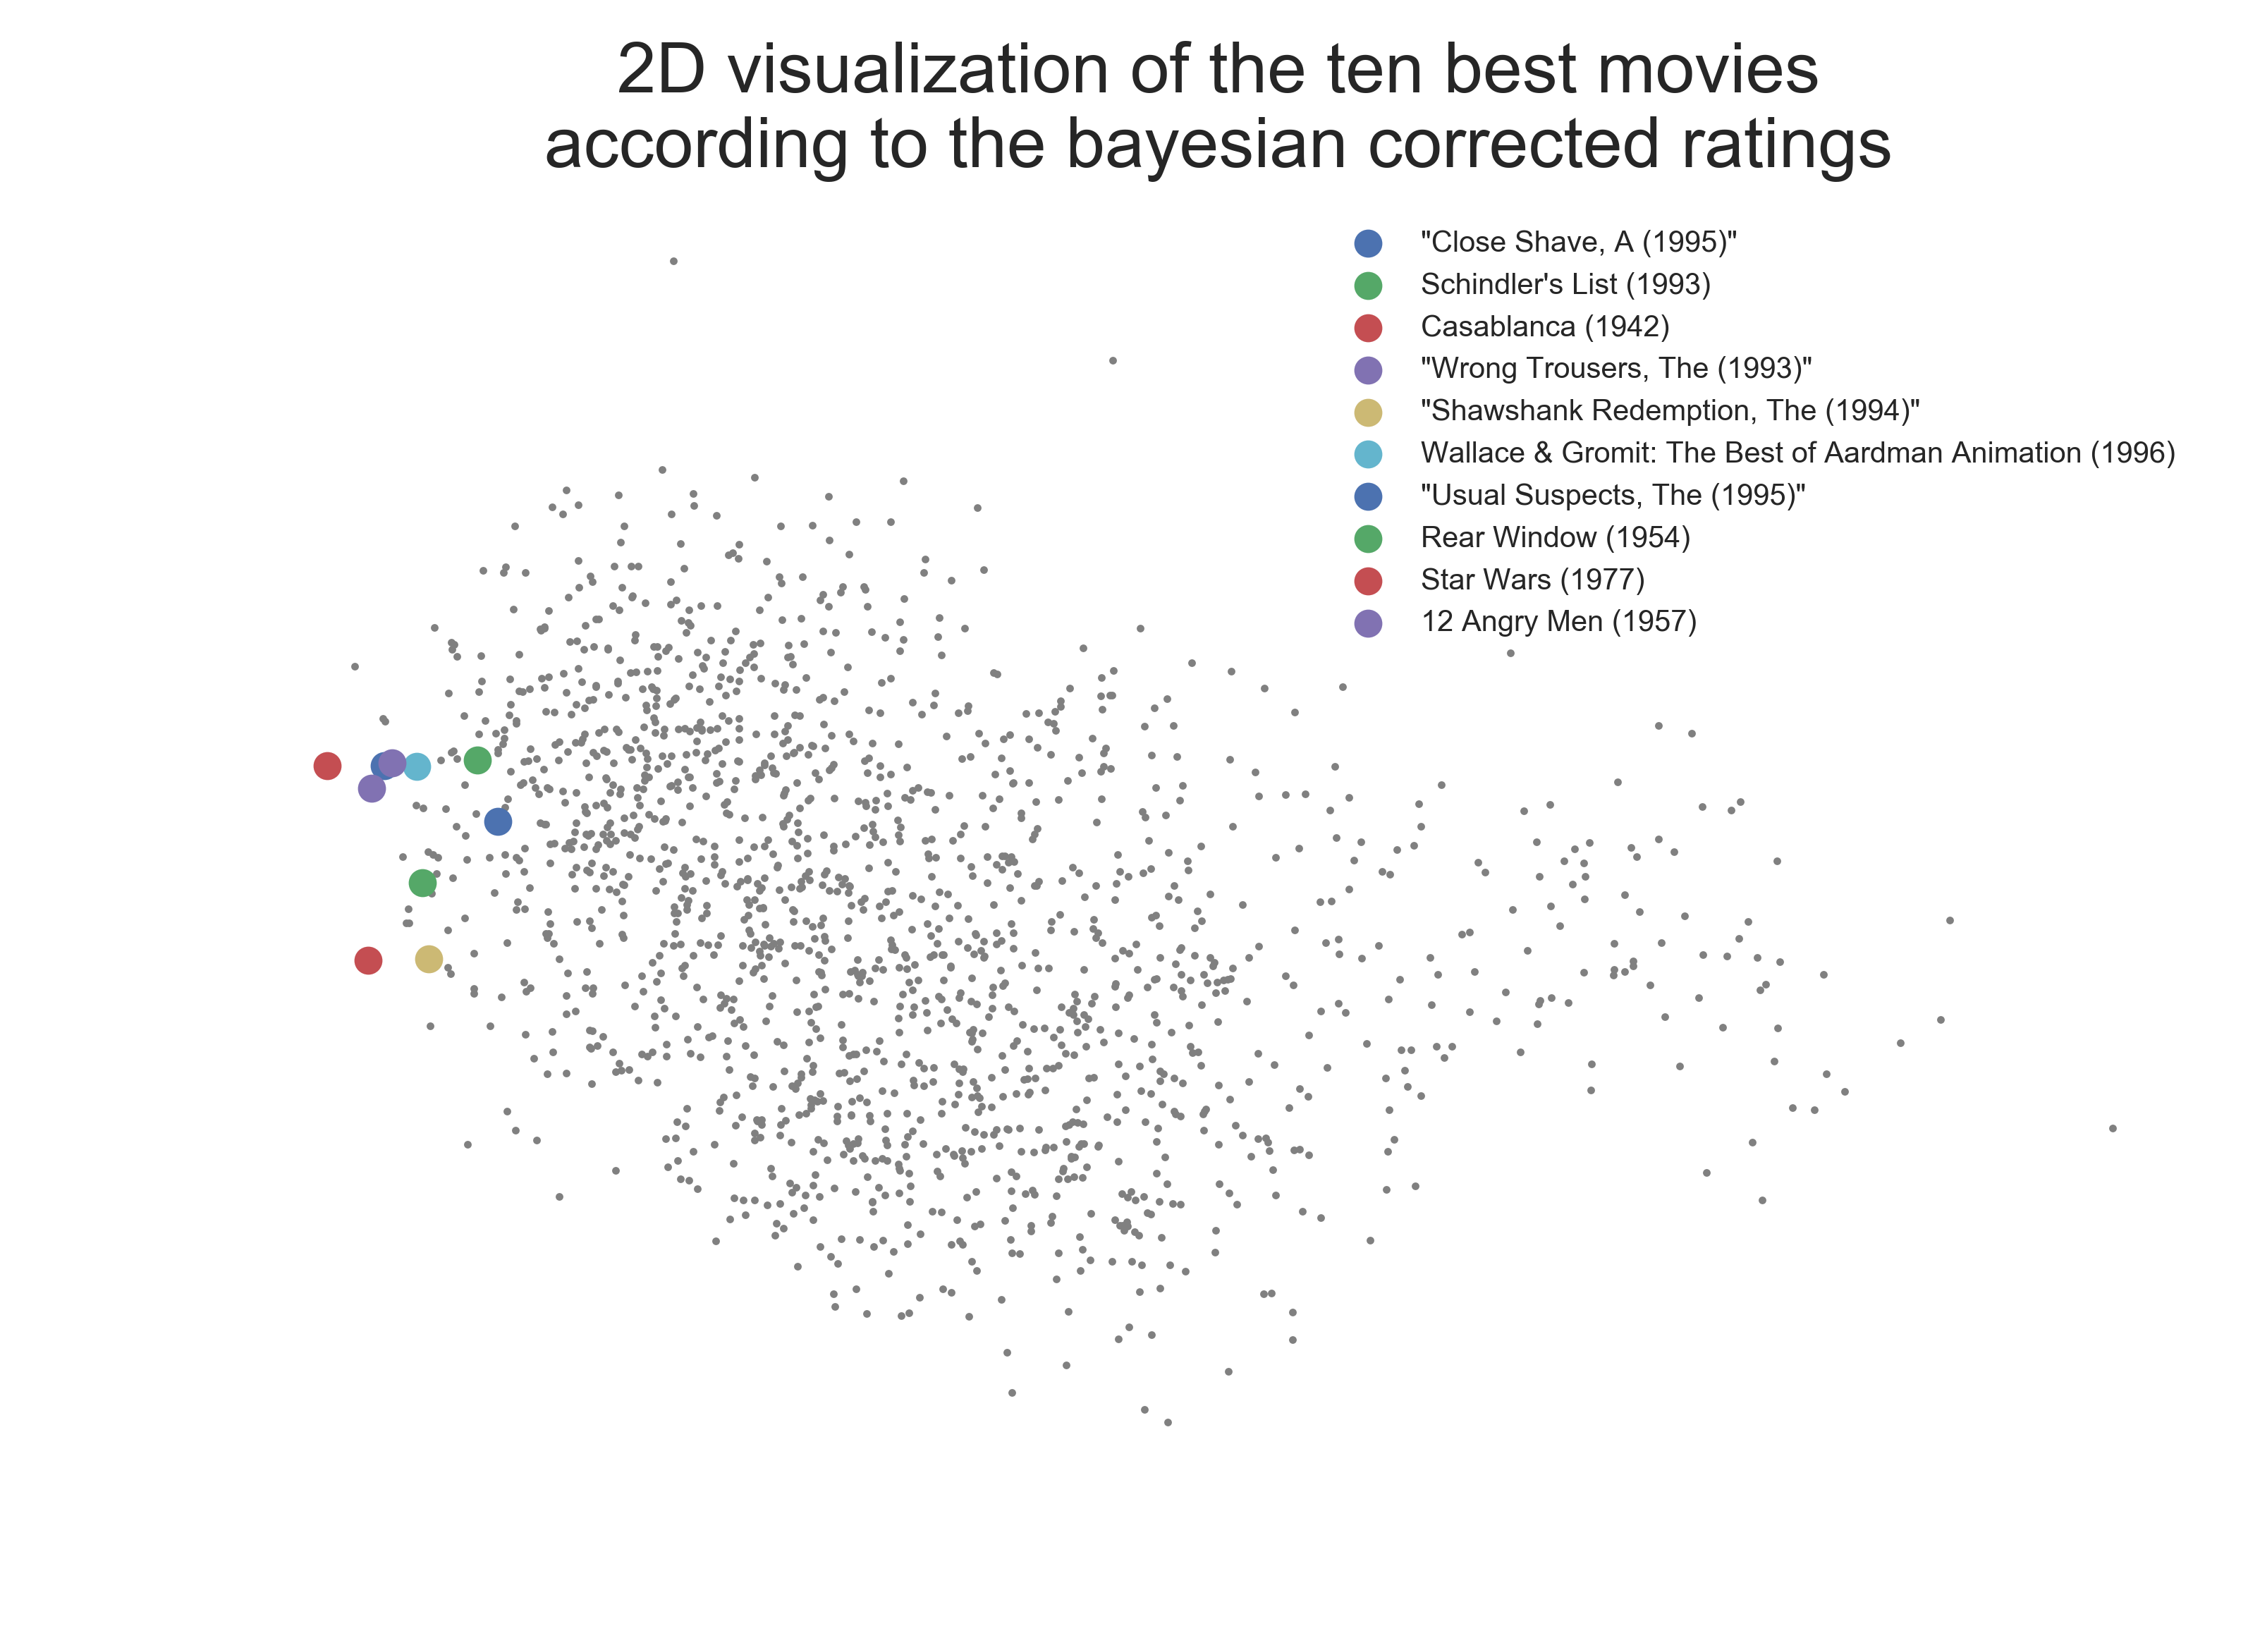

In [31]:
plt.figure(dpi=300)
plt.scatter(V2[0, :], V2[1, :], 1, 'gray')
for idx in rank_ratings_bayesian[:10]:
    plt.scatter(V2[0, idx], V2[1, idx], 20, label=movie_title[idx])
plt.axis('off')
plt.legend(prop={'size': 5})
plt.title('2D visualization of the ten best movies\naccording to the bayesian corrected ratings')
plt.show()

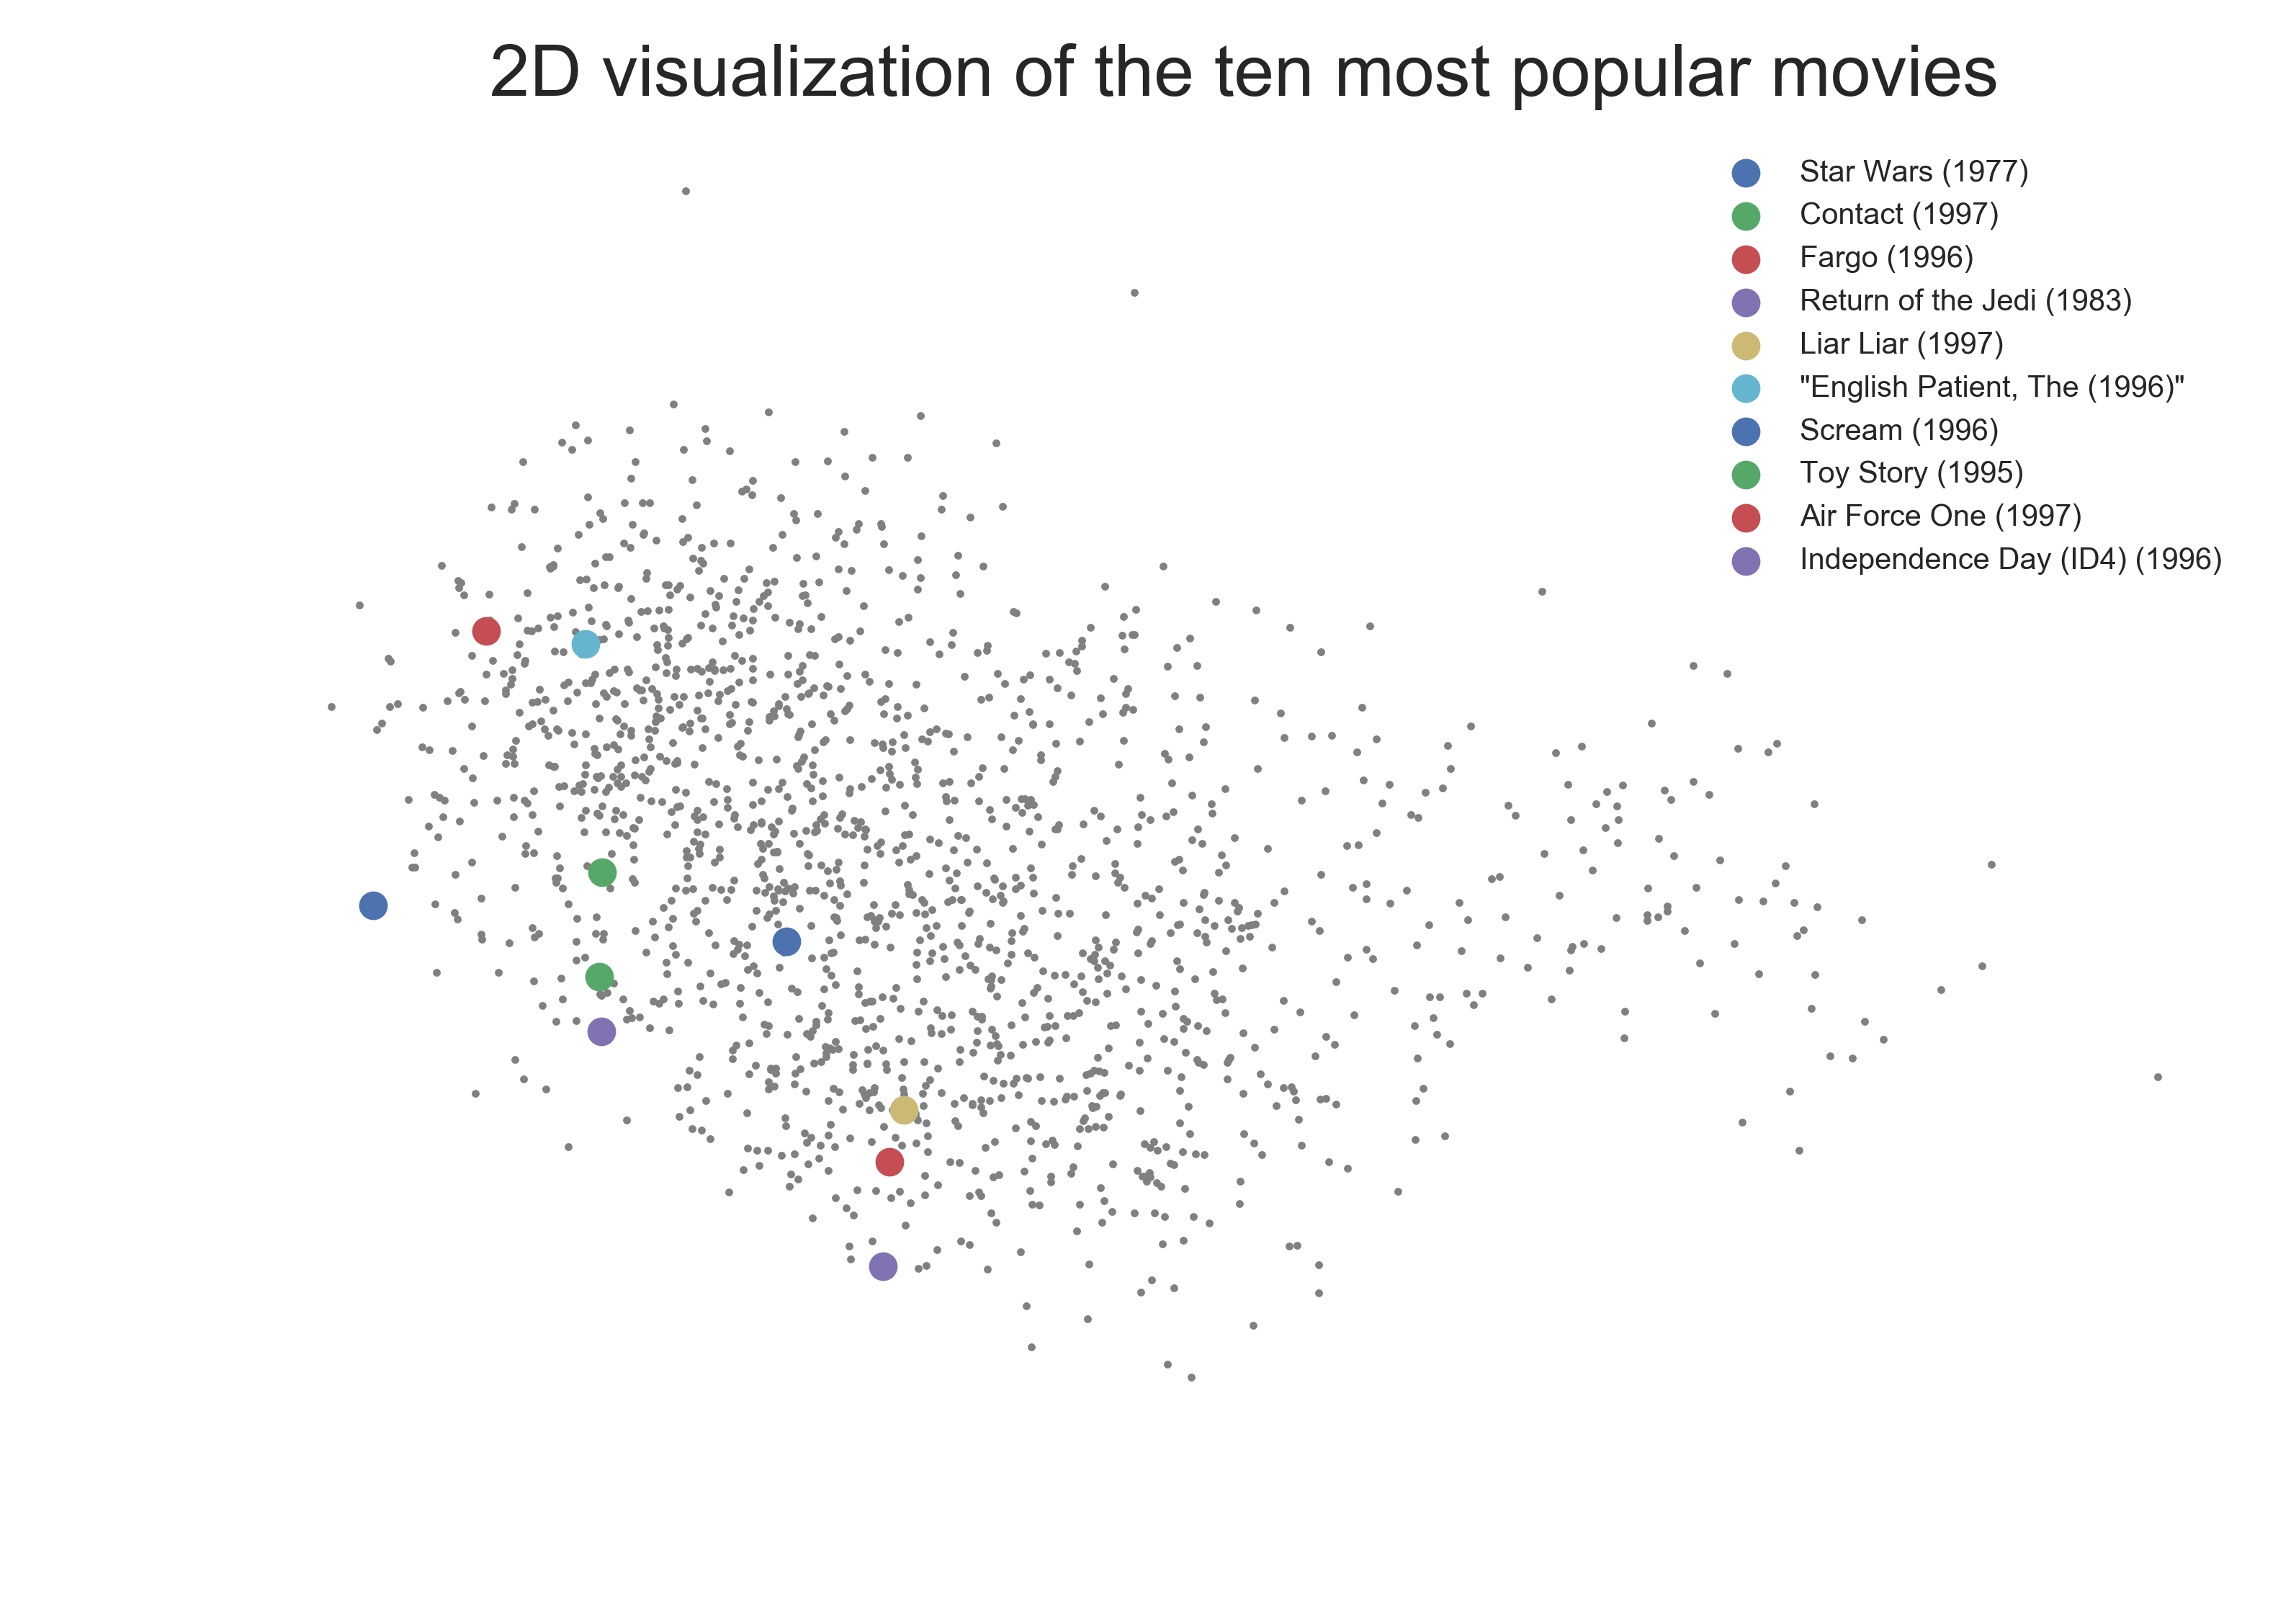

In [32]:
plt.figure(dpi=300)
plt.scatter(V2[0, :], V2[1, :], 1, 'gray')
for idx in rank_counts[:10]:
    plt.scatter(V2[0, idx], V2[1, idx], 20, label=movie_title[idx])
plt.axis('off')
plt.legend(prop={'size': 5})
plt.title('2D visualization of the ten most popular movies')
plt.show()